In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from functools import partial

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn

from tqdm.notebook import tqdm

import gymnasium as gym
from minigrid.wrappers import RGBImgPartialObsWrapper, ImgObsWrapper, FullyObsWrapper

In [9]:
device = 'cuda:3'

  0%|          | 0/1000 [00:00<?, ?it/s]

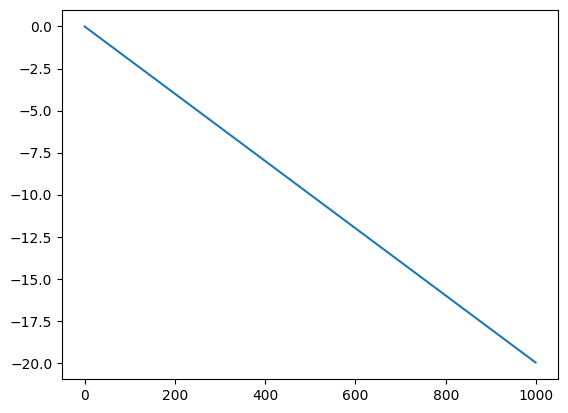

In [10]:
logits = torch.zeros(2).requires_grad_()

opt = torch.optim.Adam([logits], lr=1e-2)
losses = []
pbar = tqdm(range(1000))
for _ in pbar:
    log_sm = -torch.log_softmax(logits, dim=-1)
    
    # loss = log_sm[0]#-log_sm[1]
    loss = log_sm[0]-log_sm[1]
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    losses.append(loss.item())
    pbar.set_postfix(loss=loss.item())
plt.plot(losses)

In [11]:
class MyLavaGrid():
    def __init__(self, size_grid=100, obs_size=9, p_lava=0.15, n_envs=10, dead_screen=True):
        super().__init__()
        assert obs_size % 2==1
        self.size_grid = size_grid
        self.map = torch.rand(self.size_grid, self.size_grid) < p_lava
        self.k = k = obs_size//2
        self.map[k:k+3, k:k+3] = False
        self.map[:k] = True; self.map[:, :k] = True
        self.map[-k:] = True; self.map[:, -k:] = True
        self.n_envs = n_envs
        self.dead_screen = dead_screen

        self.action2vec = torch.tensor([[ 1,  0],
                                        [ 0,  1],
                                        [-1,  0],
                                        [ 0, -1]])
        self.reset()
        
        self.observation_space = type('', (), {})()
        self.observation_space.sample = lambda : torch.rand((self.n_envs, 2*k+1, 2*k+1), device=self.map.device)
        self.observation_space.shape = (2*k+1, 2*k+1)
        self.action_space = type('', (), {})()
        self.action_space.sample = lambda : torch.randint(0, len(self.action2vec), size=(self.n_envs, ), dtype=torch.long, device=self.map.device)
        self.action_space.n = len(self.action2vec)
        
    def to(self, *args, **kwargs):
        self.map = self.map.to(*args, **kwargs)
        self.action2vec = self.action2vec.to(*args, **kwargs)
        return self
        
    def reset(self, snapshot=None):
        if snapshot is None:
            self.snapshot = torch.full((self.n_envs, 2), self.k, dtype=torch.long, device=self.map.device)
        else:
            self.snapshot = snapshot.to(self.map.device)
        obs, done = self.calc_obs_done()
        reward = torch.zeros(self.n_envs, device=self.map.device)
        info = None # [{} for _ in range(self.n_envs)]
        return self.snapshot, obs, reward, done, info
    
    def step(self, action):
        action = self.action2vec[action]
        done = self.map[self.snapshot[:, 0], self.snapshot[:, 1]]
        self.snapshot = torch.where(done[:, None], self.snapshot, self.snapshot + action)
        self.snapshot = torch.clamp(self.snapshot, min=self.k, max=self.size_grid-self.k-1)
        
        obs, done = self.calc_obs_done()
        reward = torch.zeros(self.n_envs, device=self.map.device)
        done = self.map[self.snapshot[:, 0], self.snapshot[:, 1]]
        info = None # [{} for _ in range(self.n_envs)]
        return self.snapshot, obs, reward, done, info
    
    def calc_obs_done(self, snapshot=None):
        snapshot = self.snapshot if snapshot is None else snapshot
        obs = torch.stack([self.map[x-self.k: x+self.k+1, y-self.k: y+self.k+1] for (x, y) in snapshot]).float()
        done = self.map[snapshot[:, 0], snapshot[:, 1]]
        if self.dead_screen:
            obs[done] = 1.
        return obs, done
    
    def to_latent(self, snapshot, obs):
        done = self.map[snapshot[:, 0], snapshot[:, 1]]
        return [(tuple(a.tolist()) if not d else (-1, -1)) for a, d in zip(snapshot, done)]

In [12]:
env = MyLavaGrid(obs_size=11, dead_screen=False)
snapshot, obs, reward, done, info = env.reset()

In [13]:
snapshot, obs, reward, done, info = env.reset()
for i in range(100):
    snapshot, obs, reward, done, info = env.step(env.action_space.sample())

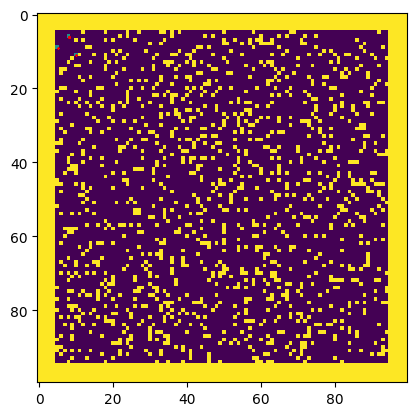

In [14]:
def render_snapshots(env, snapshot):
    img = env.map.clone().cpu().float()
    img[snapshot[:, 0], snapshot[:, 1]] = 0.5
    plt.scatter(snapshot[:, 1], snapshot[:, 0], marker='x', s=1., color='r')
    plt.imshow(img.numpy())

render_snapshots(env, snapshot)

In [369]:
def tensor_stack(a):
    if isinstance(a, torch.Tensor):
        return a
    elif isinstance(a, list):
        return torch.stack([tensor_stack(i) for i in a])
    
def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer
    
class ImitationExplorer(nn.Module):
    def __init__(self, env, force_random=False):
        super().__init__()
        self.n_inputs = np.prod(env.observation_space.shape)
        self.n_outputs = env.action_space.n
        self.encoder = nn.Sequential(
            nn.Flatten(-2, -1),
            layer_init(nn.Linear(self.n_inputs, 20)),
            nn.Tanh(),
            layer_init(nn.Linear(20, 20)),
            nn.Tanh(),
            layer_init(nn.Linear(20, 20)),
        )
        self.critic = nn.Sequential(
            layer_init(nn.Linear(20, 20)),
            nn.Tanh(),
            layer_init(nn.Linear(20, 1)),
        )
        self.actor = nn.Sequential(
            layer_init(nn.Linear(20, 20)),
            nn.Tanh(),
            layer_init(nn.Linear(20, self.n_outputs)),
        )
        self.force_random = force_random
        
    def get_logits_values(self, x):
        x = self.encoder(x)
        logits, values = self.actor(x), self.critic(x)
        return logits, values
    
    def get_action_and_value(self, x, action=None, ret_logits=False):
        x = self.encoder(x)
        logits, values = self.actor(x), self.critic(x)
        if self.force_random:
            logits, values = torch.zeros_like(logits), torch.zeros_like(values)
        dist = torch.distributions.Categorical(logits=logits)
        if action is None:
            action = dist.sample()
        return action, dist.log_prob(action), dist.entropy(), values

# do_training(10, 2048)
class RandomExplorer(nn.Module):
    def __init__(self):
        super().__init__()
        
    def get_action_and_value(self, x, action=None):
        logits = torch.zeros(x.shape[:-1]+(4,))
        probs = torch.distributions.Categorical(logits=logits)
        if action is None:
            action = probs.sample()
        return action, probs.log_prob(action), probs.entropy(), 0.

In [604]:
def step_policy(ge, explorer, opt, calc_prod, n_steps, batch_size=100, coef_entropy=1e-1, viz=False, device=None):
    # list of tuples (snapshot, obs, action, reward, done)
    obs = torch.stack([trans[1] for node in ge for trans in node.traj])
    action = torch.stack([trans[2] for node in ge for trans in node.traj])
    # mask_done = torch.stack([trans[4] for node in ge for trans in node.traj])
    mask_done = torch.stack([node.done for node in ge])
    prod = calc_prod(ge)
    prod_norm = (prod-prod[~mask_done].mean())/(prod[~mask_done].std()+1e-9)
    r = prod_norm[1:]
    
    losses = []
    entropies = []
    logits_list = []
    for i_batch in range(n_steps):
        idx = torch.randperm(len(obs))[:batch_size]
        b_obs, b_action, b_r = obs[idx].to(device), action[idx].to(device), r[idx].to(device)
        # if norm_batch:
            # b_prod = (b_prod-b_prod.mean())/(b_prod.std()+1e-9)
            
        logits, values = explorer.get_logits_values(b_obs)
        # logits_aug = b_r[:, None]*logits
        # logits_aug = (1./b_r[:, None])*logits
        logits_aug = torch.sign(b_r[:, None])*logits
        dist = torch.distributions.Categorical(logits=logits_aug)
        log_prob = dist.log_prob(b_action)
        entropy = dist.entropy()
        
        loss_data = (-log_prob*b_r.abs()).mean()
        loss_entropy = -entropy.mean()
        
        loss = loss_data + coef_entropy*loss_entropy

        opt.zero_grad()
        loss.backward()
        opt.step()
        
        losses.append(loss.item())
        entropies.append(entropy.mean().item())
        logits_list.append(logits.mean().item())
        
        # pbar.set_postfix(loss=loss.item())
    losses = torch.tensor(losses)
    # print(f'Reduced loss from {losses[0].item()} to {losses[-1].item()}')

    if viz:
        plt.figure(figsize=(15, 5))
        plt.subplot(131); plt.plot(losses); plt.title('loss vs time')
        plt.subplot(132); plt.plot(entropies); plt.title('entropy vs time')
        plt.subplot(133); plt.plot(logits_list); plt.title('logits mean vs time')
        plt.show()
        
        # plt.plot(logits.softmax(dim=-1).mean(dim=-2).detach().cpu().numpy())
        # plt.hist(logits.argmax(dim=-1).detach().cpu().numpy())
        # plt.ylim(.23, .27)
        # plt.title('avg prob distribution')
        # plt.show()
        
        # plt.scatter(b_action.detach().cpu().numpy(), log_prob.detach().cpu().numpy())
        # plt.show()
        # plt.scatter(b_prod.cpu().numpy(), loss1.detach().cpu().numpy())
        # plt.show()
        
        # for i in range(4):
            # print(f'Action {i}')
            # print(log_probs[batch_actions==i].mean().item())

In [605]:
data = {}
for force_random in [True, False]:
# for force_random in [False]:
    np.random.seed(0)
    torch.manual_seed(0)
    device = 'cuda:3'

    n_envs = 10
    env = MyLavaGrid(obs_size=3, n_envs=n_envs, dead_screen=False).to(device)
    snapshot, obs, reward, done, info = env.reset()
    explorer = ImitationExplorer(env, force_random=force_random).to(device)
    opt = torch.optim.Adam(explorer.parameters(), lr=1e-3)
    ge = GoExplore(env, explorer, device)

    cellsvtime, deadvtime = [], []
    pbar = tqdm(range(500))
    for i in pbar:
        nodes = ge.select_nodes(n_envs)
        ge.explore_from(nodes, 1, 10)

        if i%10==0:
            step_policy(ge, explorer, opt, calc_prods_novelty, 20, batch_size=5000, coef_entropy=0., viz=False, device=device)

        n_seen = torch.tensor(list(ge.cell2n_seen.values()))
        done = torch.stack([node.done for node in ge])
        pbar.set_postfix(cells=len(ge.cell2node), n_seen_max=n_seen.max().item())
        cellsvtime.append(len(ge.cell2node))
        deadvtime.append(done.sum().item())
        
    data[force_random] = dict(ge=ge, explorer=explorer, cellsvtime=cellsvtime, deadvtime=deadvtime)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

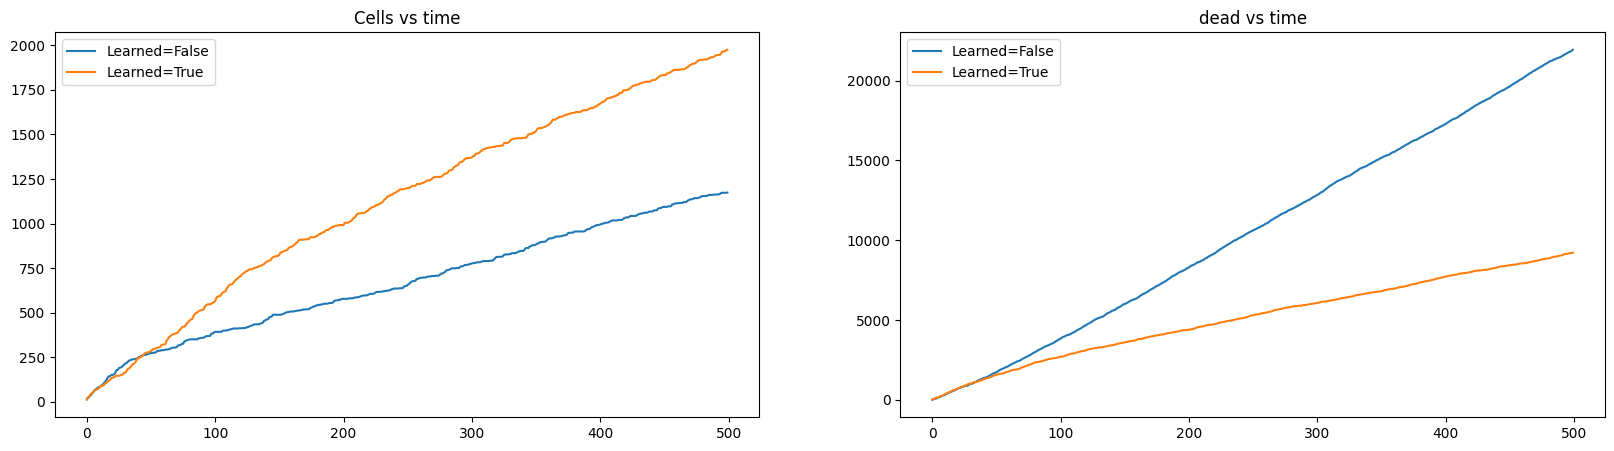

In [606]:
plt.figure(figsize=(20, 5))
plt.subplot(121)
for force_random, d in data.items():
    plt.plot(d['cellsvtime'], label=f'Learned={not force_random}')
plt.title('Cells vs time')
plt.legend()

plt.subplot(122)
for force_random, d in data.items():
    plt.plot(d['deadvtime'], label=f'Learned={not force_random}')
plt.title('dead vs time')
plt.legend()
plt.show()

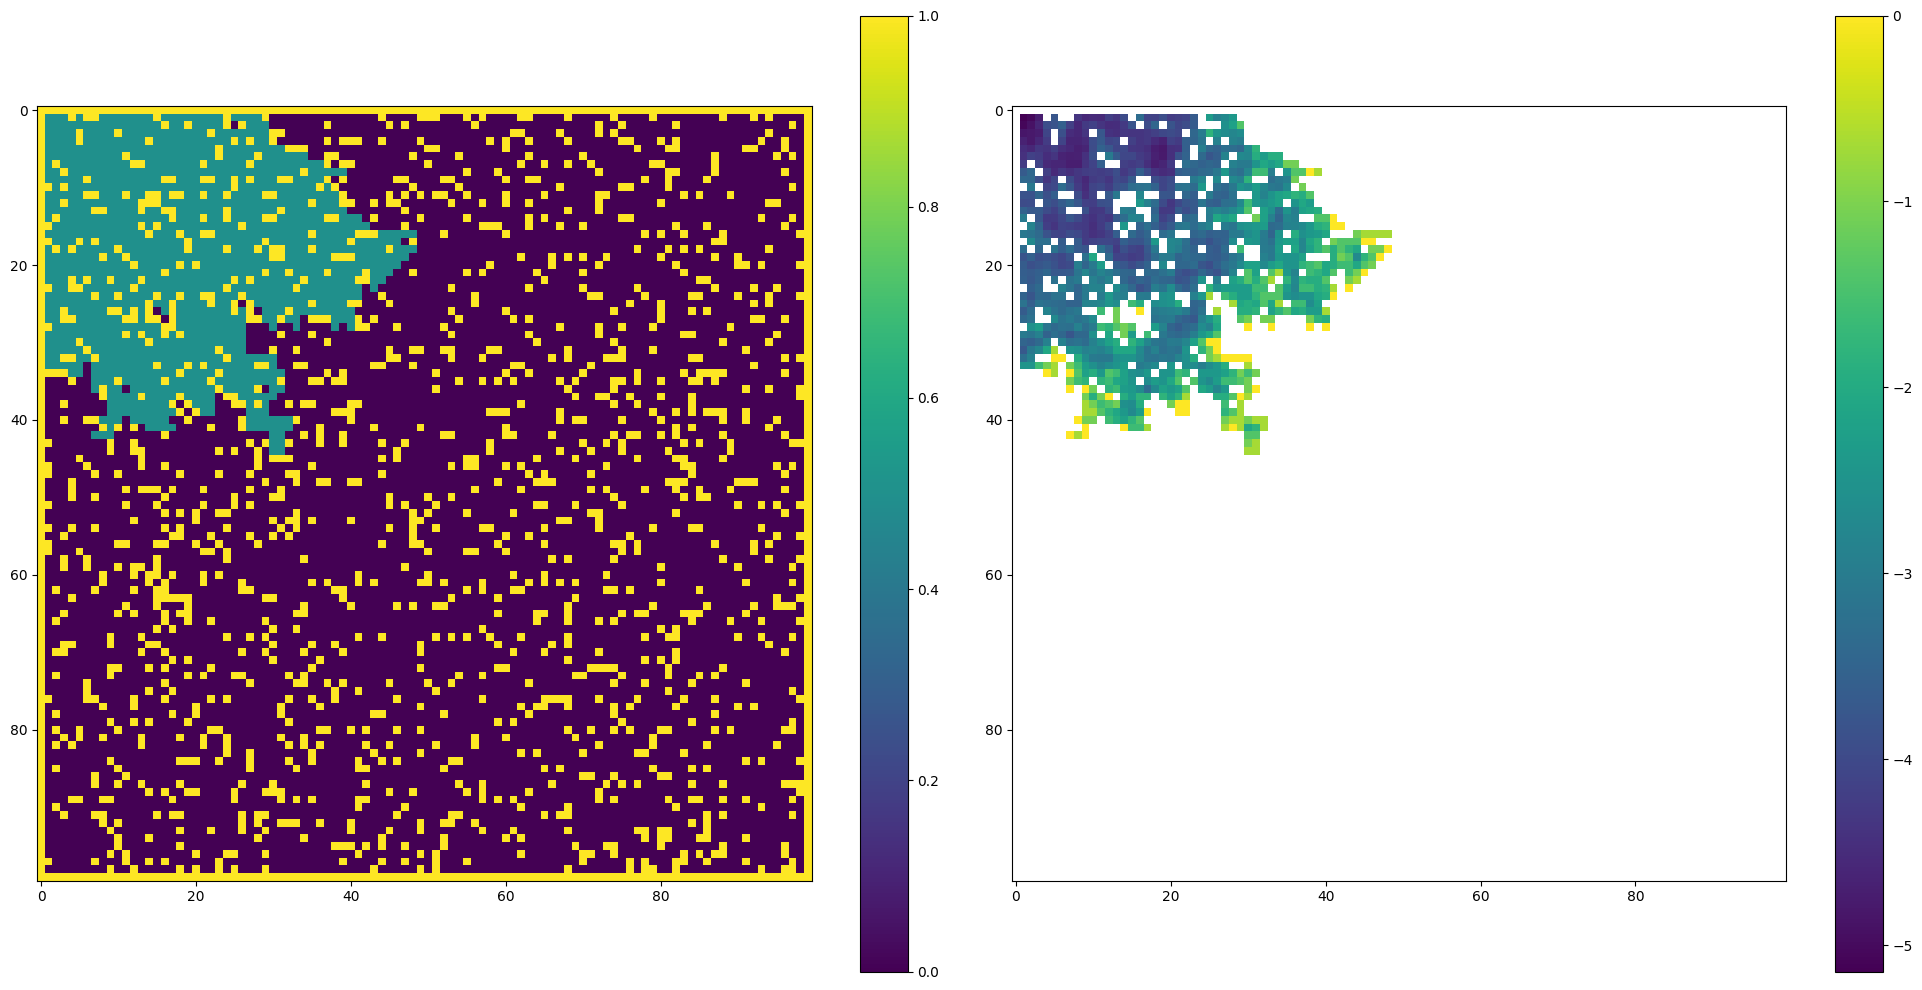

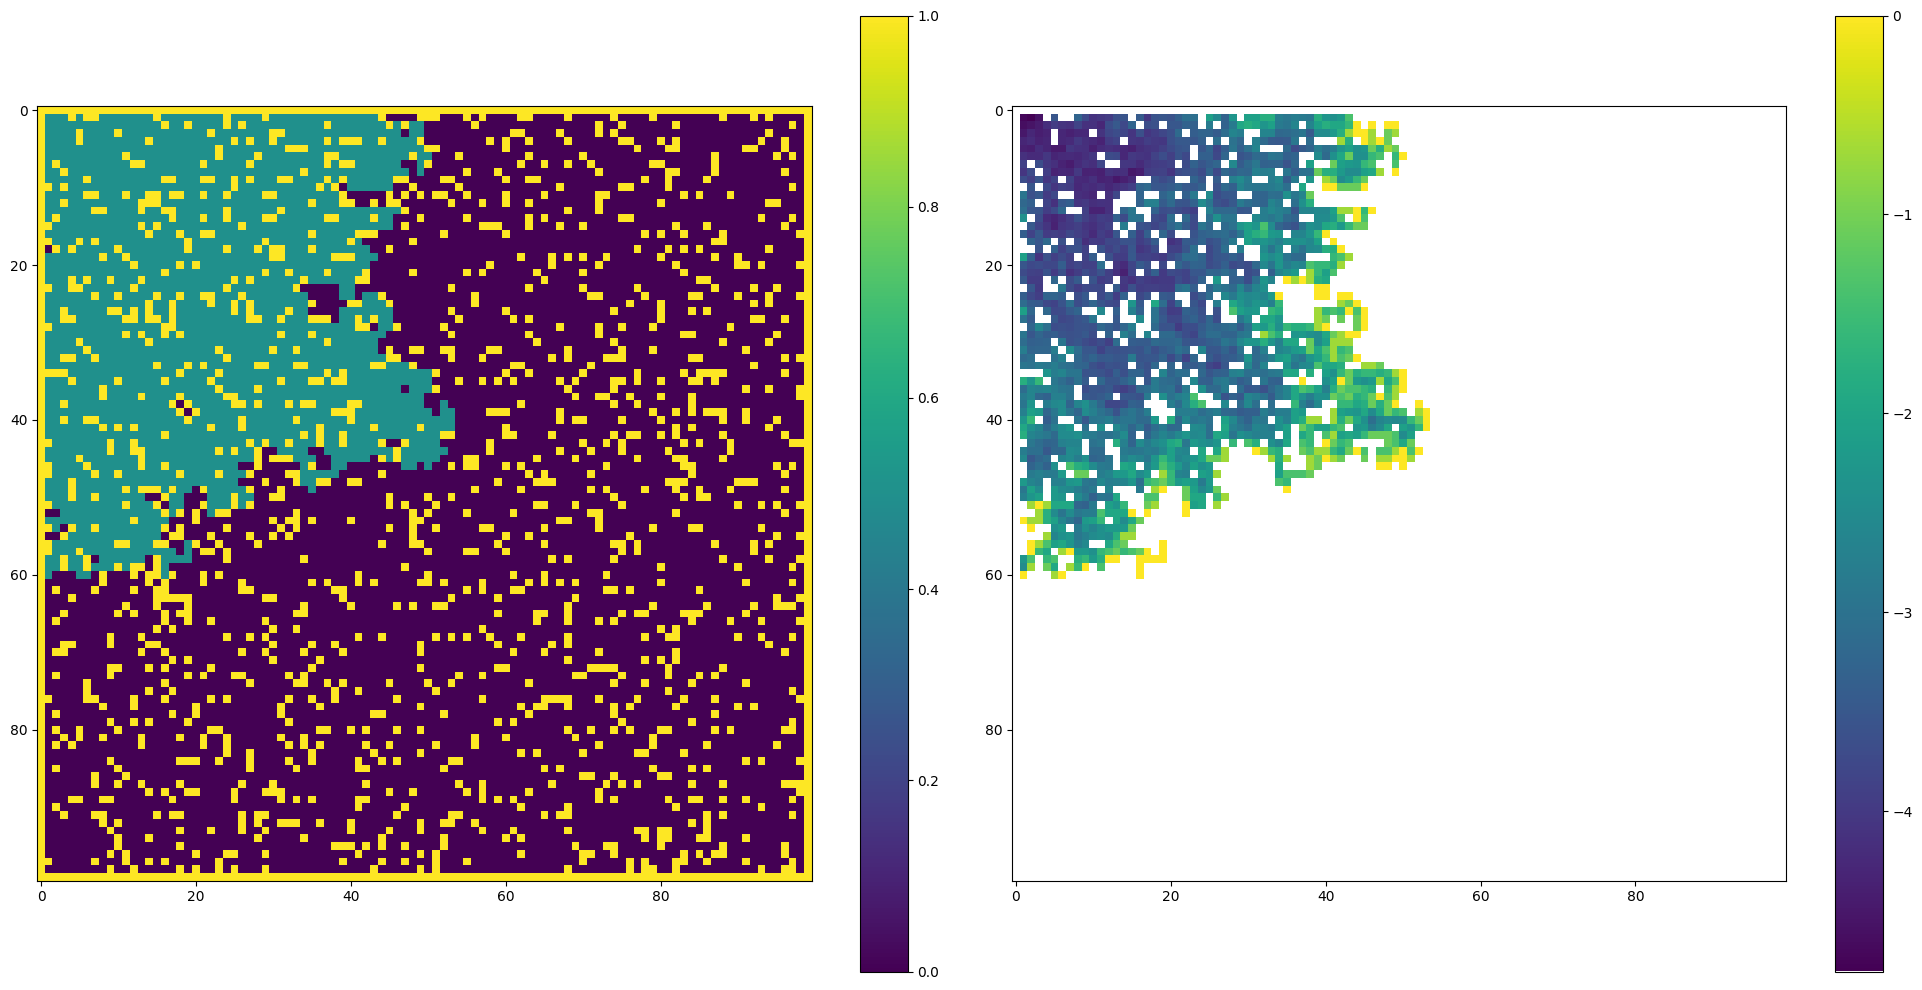

In [607]:
render_snapshots(data[True]['ge'])
plt.show()
render_snapshots(data[False]['ge'])
plt.show()

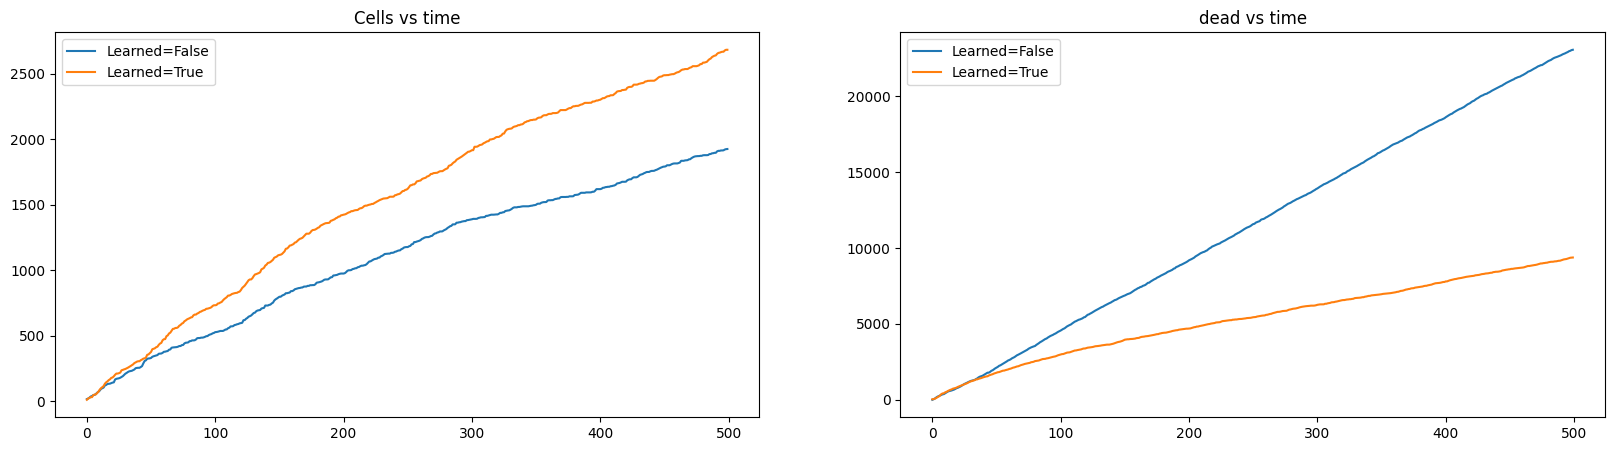

In [569]:
plt.figure(figsize=(20, 5))
plt.subplot(121)
for force_random, d in data.items():
    plt.plot(d['cellsvtime'], label=f'Learned={not force_random}')
plt.title('Cells vs time')
plt.legend()

plt.subplot(122)
for force_random, d in data.items():
    plt.plot(d['deadvtime'], label=f'Learned={not force_random}')
plt.title('dead vs time')
plt.legend()
plt.show()

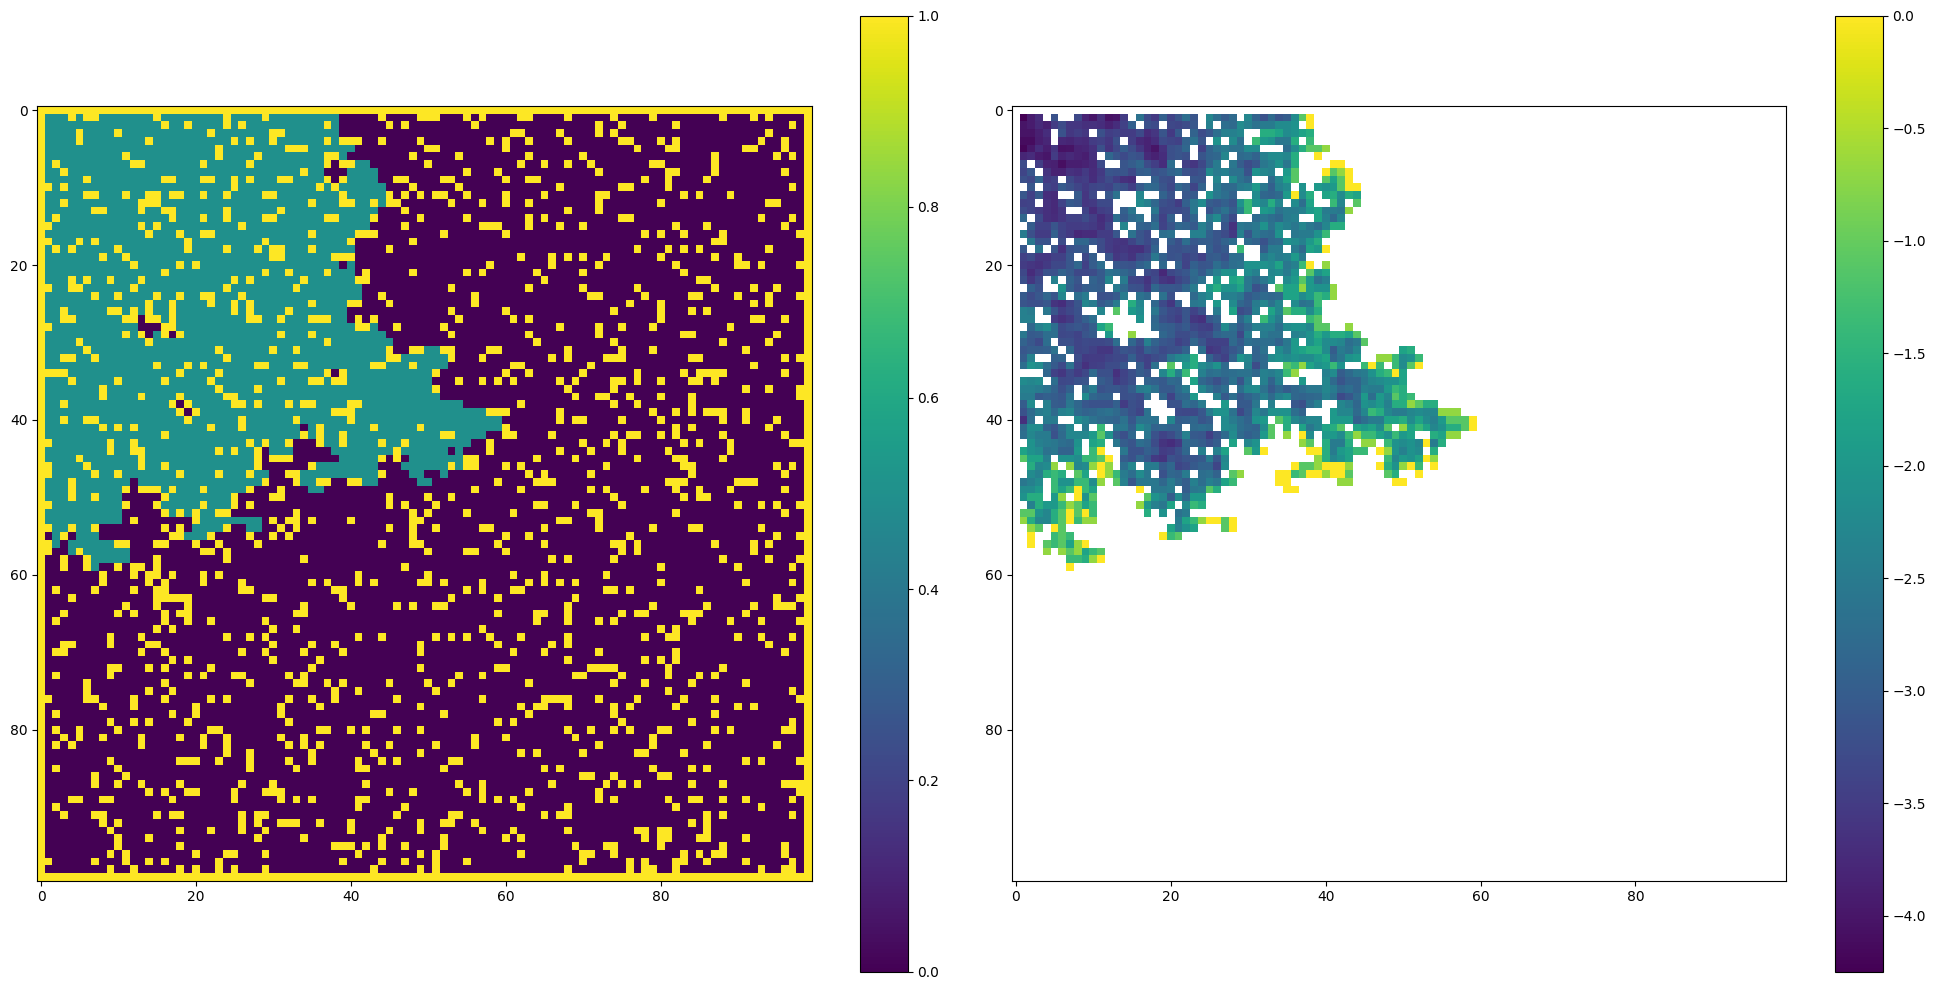

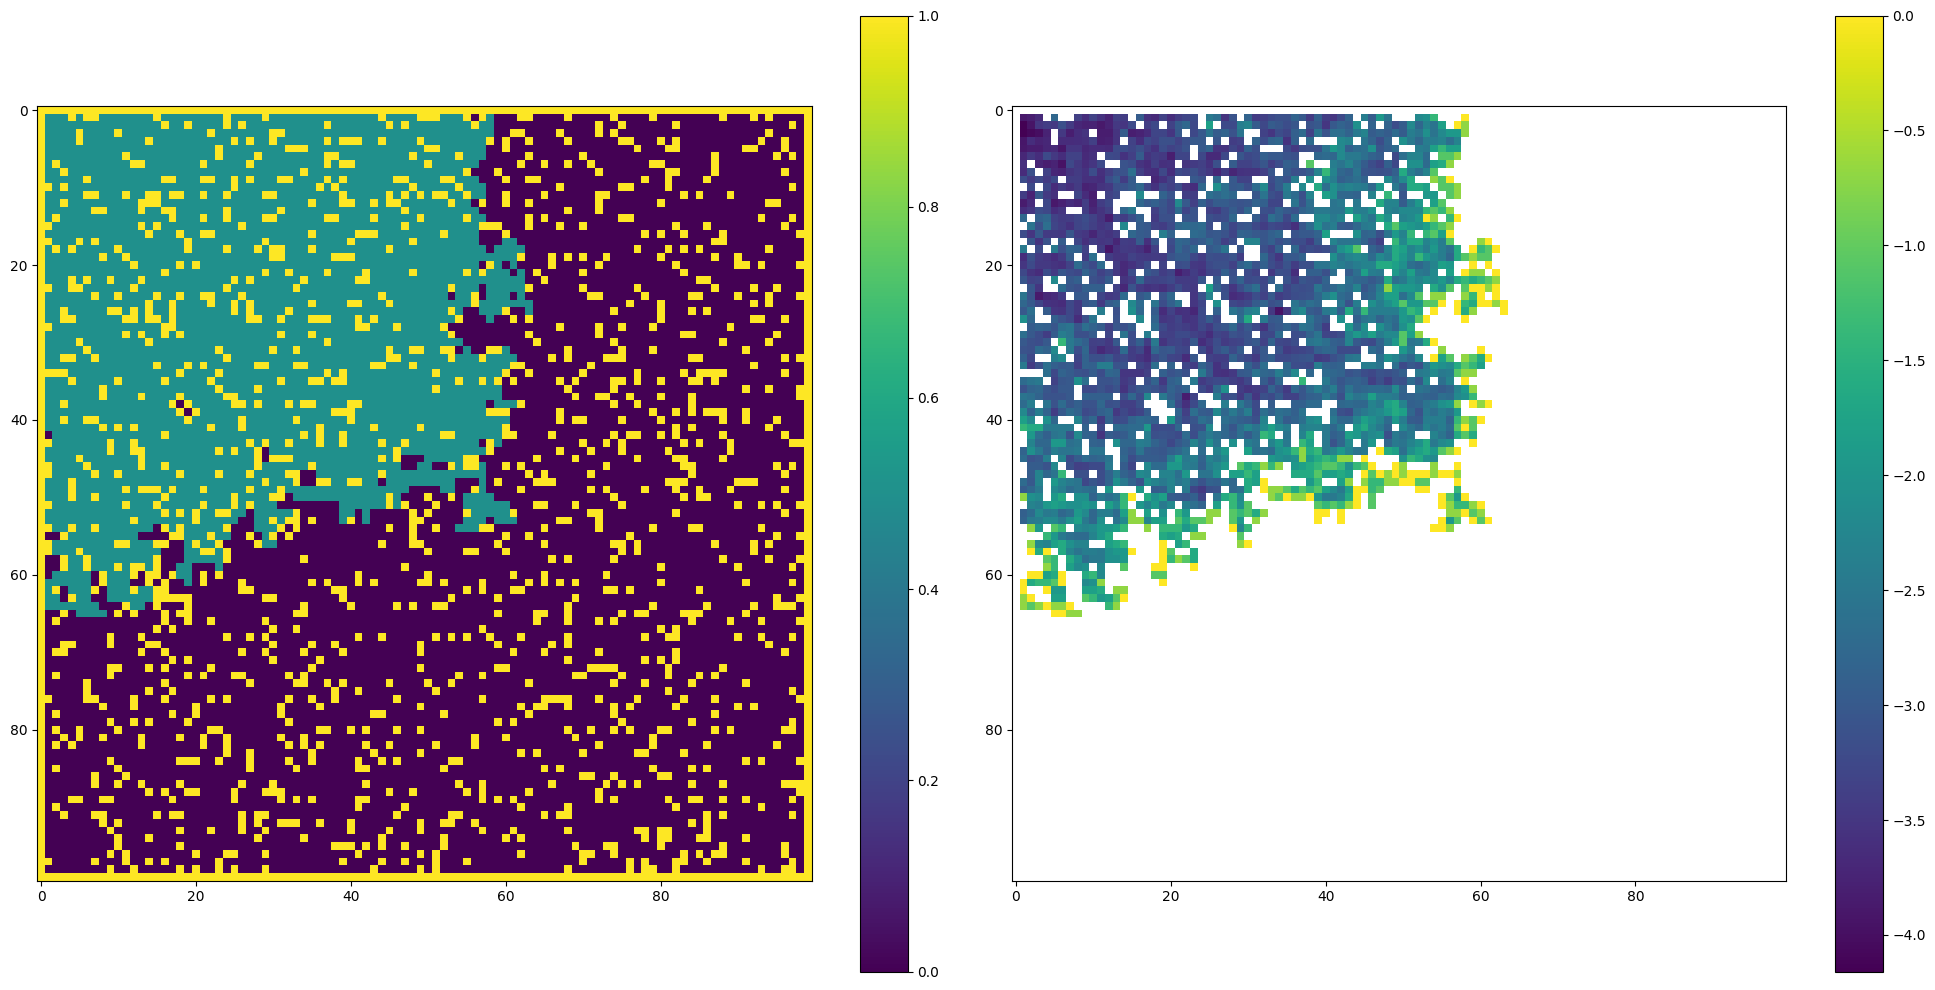

In [570]:
render_snapshots(data[True]['ge'])
plt.show()
render_snapshots(data[False]['ge'])
plt.show()

In [614]:
ex = data[False]['explorer']

In [615]:
x = torch.zeros(3,3).to(device)
# x[2, 1] = 1.
print(x)

logits, _ = ex.get_logits_values(x[None])

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], device='cuda:3')


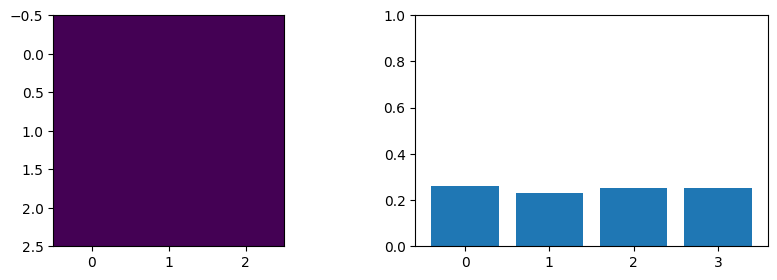

In [616]:
plt.figure(figsize=(10, 3))
plt.subplot(121)
plt.imshow(x.cpu().numpy())
plt.subplot(122)
plt.bar(torch.arange(4), logits[0].softmax(dim=-1).tolist())
plt.ylim(0, 1)
plt.show()

tensor([-2.5928,  2.6178], requires_grad=True)
tensor([0.0054, 0.9946], grad_fn=<SoftmaxBackward0>)


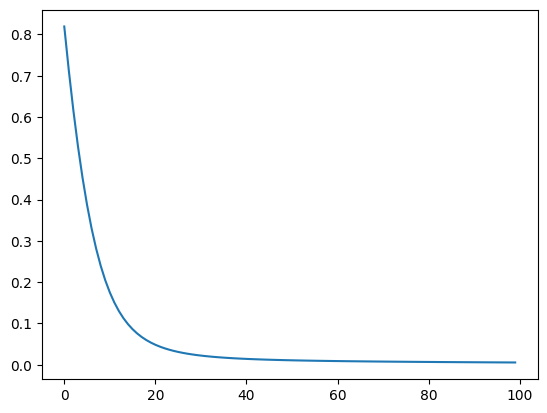

In [551]:
def run_small():
    obs = torch.zeros(2, 2)
    obs[:2, 0] = 1.
    # obs[2:, 1] = 1.
    # action = torch.tensor([0,1,0, 1])
    action = torch.tensor([0,1])
    
    r = torch.tensor([-1, 1]).float()
    
    logits = (1e-1*torch.randn(2)).requires_grad_()
    opt = torch.optim.Adam([logits], lr=1e-1)
    
    losses = []
    for _ in range(100):
        l = logits.repeat(2, 1) * (r[:, None])
        log_sm = torch.log_softmax(l, dim=-1)
        
        logprob = log_sm[torch.arange(2), action]
        
        loss = (-logprob).mean()
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        losses.append(loss.item())
    
    plt.plot(losses)
    print(logits)
    print(logits.softmax(dim=-1))
    
    # print(obs)
    # print(action)
    # print(r)

run_small()

In [40]:
explorer = ImitationExplorer(env, force_random=False)

In [41]:
o = env.observation_space.sample()
logits, _ = explorer.get_logits_values(o)

In [42]:
logits.shape

torch.Size([10, 4])

In [295]:
from dataclasses import dataclass, field

@dataclass
class Node:
    parent: Node
    traj: list[Node]
    snapshot: tuple
    obs: torch.Tensor
    latent: tuple
    
    children: list[Node] = field(default_factory=list)
    
    

In [617]:
class Node():
    def __init__(self, parent, traj, snapshot, obs, latent, done):
        self.parent = parent
        self.children = []
        
        self.traj = traj

        self.snapshot = snapshot
        self.obs = obs
        self.latent = latent
        self.done = done
        
    def get_full_trajectory(self):
        return ([] if self.parent is None else self.parent.get_full_trajectory()) + self.traj

from collections import defaultdict
class GoExplore(list):
    def __init__(self, env, explorer, device=None):
        self.env = env
        self.explorer = explorer
        self.device = device

        self.cell2node = {}
        self.cell2n_seen = defaultdict(lambda : 0)
        snapshot, obs, reward, done, info = self.env.reset()
        node_root = Node(None, [], snapshot[0].cpu(), obs[0].cpu(), self.env.to_latent(snapshot, obs)[0], done[0].cpu())
        self.node_root = node_root
        self.add_node(node_root)
        
    def add_node(self, node):
        self.cell2node[node.latent] = node
        self.append(node)
        if node.parent:
            node.parent.children.append(node)
        
    def add_node(self, node):
        self.cell2n_seen[node.latent] += 1
        self.append(node)
        if node.parent:
            node.parent.children.append(node)
            
        if node.latent in self.cell2node:
            node_old = self.cell2node[node.latent]
            if len(node.get_full_trajectory())<len(node_old.get_full_trajectory()):
                self.cell2node[node.latent] = node
        else:
            self.cell2node[node.latent] = node
    
    def select_nodes(self, n_nodes):
        cells = list(self.cell2node.keys())
        n_seen = np.array([self.cell2n_seen[cell] for cell in cells])
        p = 1./np.sqrt(n_seen+1)
        p = p/p.sum()
        # p = None
        return [self.cell2node[cells[i]] for i in np.random.choice(len(cells), size=n_nodes, p=p)]
    
    def explore_from_single(self, nodes, len_traj):
        trajs = [[] for _ in nodes] # list of tuples (snapshot, obs, action, reward, done)
        snapshot = torch.stack([node.snapshot for node in nodes]).to(device)
        snapshot, obs, reward, done, info = env.reset(snapshot)
        for i_trans in range(len_traj):
            with torch.no_grad():
                action, log_prob, entropy, values = self.explorer.get_action_and_value(obs)
                # action, log_prob = action.cpu(), log_prob.cpu()
            snapshot_next, obs_next, reward, done_next, info = self.env.step(action)
            for i, traj in enumerate(trajs):
                traj.append((snapshot[i].cpu(), obs[i].cpu(), action[i].cpu(), reward[i].cpu(), done[i].cpu()))
            snapshot, obs, done = snapshot_next, obs_next, done_next
            
        latent = env.to_latent(snapshot, obs)
        return [Node(nodes[i], trajs[i], snapshot[i].cpu(), obs[i].cpu(), latent[i], done[i].cpu()) for i in range(len(nodes))]
    
    def explore_from(self, nodes, len_traj, n_trajs, add_nodes=True):
        for node in nodes:
            self.cell2n_seen[node.latent] += 1
            
        for _ in range(n_trajs):
            nodes = self.explore_from_single(nodes, len_traj)
            if add_nodes:
                for node in nodes:
                    self.add_node(node)

#     def step_explore(self, n_trajs, len_traj):
#         nodes = []
#         dones = []
#         for i_traj in range(n_trajs):
#             node_start = self.select_node()
#             self.env.reset(node_start.state_sim)
#             node_end, latents, done = self.explore_from(node_start, len_traj)
#             nodes.append(node_end)
#             dones.append(done)
            
#             for latent in latents:
#                 self.archive.cell2n_seen[latent] += 1
#             better = self.archive.add_if_better(node_end)
#             if better:
#                 self.trajs_good.append(node_end.traj)
#             else:
#                 self.trajs_bad.append(node_end.traj)
#         return nodes, latents, np.array(dones).mean()


In [311]:
np.random.seed(0)
torch.manual_seed(0)
device = 'cuda:3'

n_envs = 10
env = MyLavaGrid(obs_size=3, n_envs=n_envs, dead_screen=False).to(device)
snapshot, obs, reward, done, info = env.reset()
explorer = ImitationExplorer(env, force_random=True).to(device)
ge = GoExplore(env, explorer, device)
pbar = tqdm(range(500))
archive_size = []
for i in pbar:
    nodes = ge.select_nodes(n_envs)
    ge.explore_from(nodes, 1, 10)
    n_seen = torch.tensor(list(ge.cell2n_seen.values()))
    
    pbar.set_postfix(cells=len(ge.cell2node), n_seen_max=n_seen.max().item())
    archive_size.append(len(ge.cell2node))

  0%|          | 0/500 [00:00<?, ?it/s]

In [312]:
# trajs = [node.get_full_trajectory() for node in ge if not node.children]

# for traj in trajs:
#     x = torch.stack([trans[0] for trans in traj]).float()
#     # print(x)
#     x = x+5e-2*torch.randn_like(x)
#     plt.plot(*x.numpy().T)
# plt.xlim(0, 8)
# plt.ylim(0, 15)

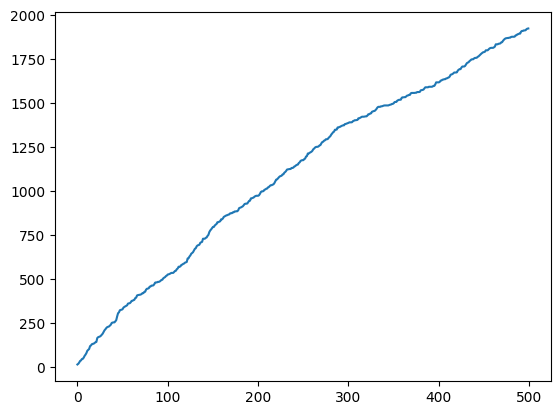

In [313]:
plt.plot(archive_size)
plt.show()

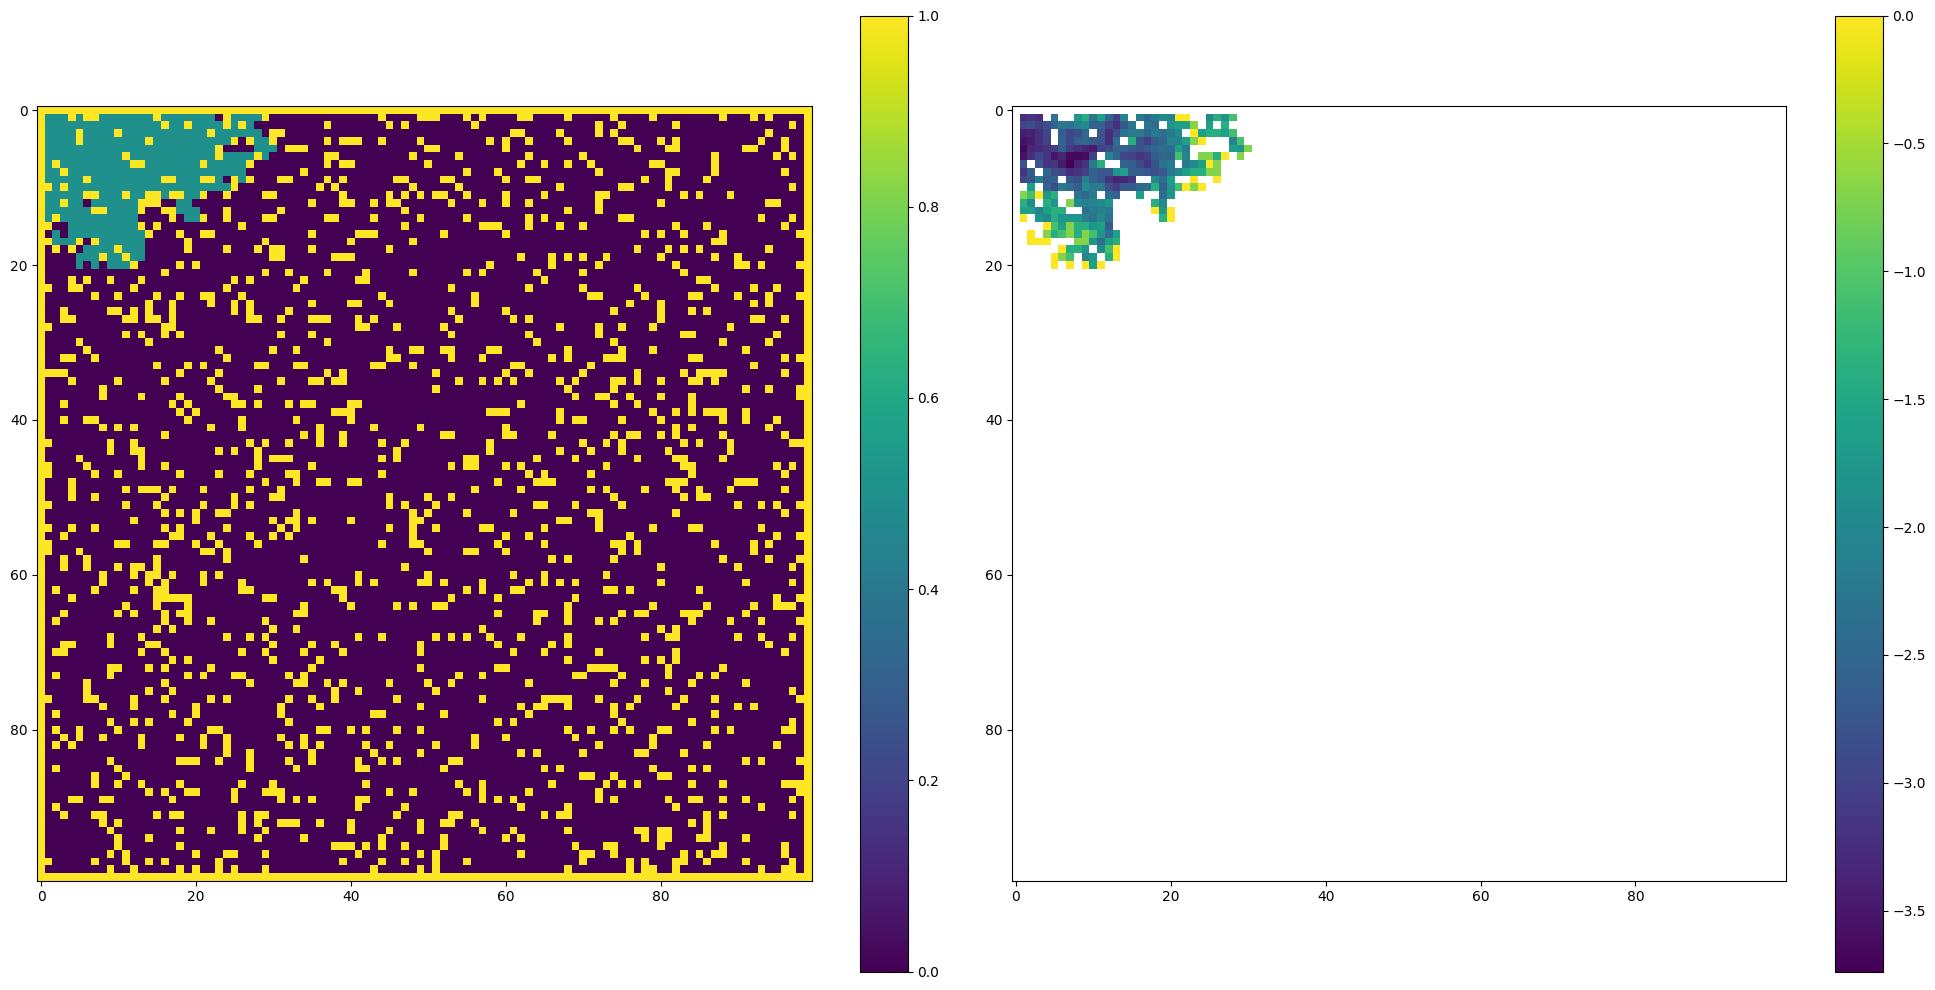

In [448]:
def render_snapshots(ge):
    cells = [cell for cell in ge.cell2node.keys() if cell!=(-1, -1)]
    snapshot = torch.stack([ge.cell2node[cell].snapshot for cell in cells])
    n_seen = torch.tensor([ge.cell2n_seen[cell] for cell in cells]).float()
    # n_seen = torch.tensor([node2prod[ge.cell2node[cell]] for cell in cells])
    
    # plt.plot(n_seen.sort(descending=True).values.numpy())
    # plt.yscale('log')
    # plt.show()
    
    plt.figure(figsize=(20, 10))
    plt.subplot(121)
    img = ge.env.map.clone().cpu().float()
    img[snapshot[:, 0], snapshot[:, 1]] = 0.5
    # plt.scatter(snapshot[:, 1], snapshot[:, 0], marker='x', s=1., color='r')
    plt.imshow(img.numpy())
    plt.colorbar()
    
    plt.subplot(122)
    img = torch.zeros_like(ge.env.map.clone().cpu().float())
    img[...] = float('nan')
    img[snapshot[:, 0], snapshot[:, 1]] = -n_seen.log()
    plt.imshow(img.numpy())#, vmin=-40, vmax=0)
    plt.colorbar()
    
#     plt.subplot(223)
#     img = ge.env.map.clone().cpu().float().repeat(3, 1, 1).permute(1, 2, 0)
#     img[snapshot[:, 0], snapshot[:, 1], 1] = n_seen/n_seen.max()
#     # plt.scatter(snapshot[:, 1], snapshot[:, 0], marker='x', s=1., color='r')
#     plt.imshow(img.numpy())
#     plt.colorbar()
    
#     plt.subplot(224)
#     img = torch.zeros_like(ge.env.map).cpu().float().repeat(3, 1, 1).permute(1, 2, 0)
#     img[:, :, 0] = ge.env.map.cpu().float()
#     img[snapshot[:, 0], snapshot[:, 1], :] = .5
#     img[snapshot[:, 0], snapshot[:, 1], 2] += n_seen/n_seen.max()
#     img = img.clamp(0, 1)
#     # plt.scatter(snapshot[:, 1], snapshot[:, 0], marker='x', s=1., color='r')
#     plt.imshow(img.numpy())
#     plt.colorbar()
    
    plt.tight_layout()

render_snapshots(ge)

In [324]:
def calc_prods_dfs(ge, reduce1=np.max, reduce2=np.max):
    node2prod = {}
    def recurse(node):
        novelty = -ge.cell2n_seen[node.latent]
        if node.children:
            for child in node.children:
                recurse(child)
            prods_children = [node2prod[child] for child in node.children]
            if reduce2 is None:
                prod = reduce1([novelty]+prods_children)
            else:
                prod = reduce1([novelty, reduce2(prods_children)])
        else:
            prod = novelty
        node2prod[node] = prod
    recurse(ge.node_root)
    prod = torch.tensor([node2prod[node] for node in ge]).float()
    prod = -(-prod).log()
    return prod

def calc_prods_novelty(ge, log=True):
    n_seen = torch.tensor([ge.cell2n_seen[node.latent] for node in ge]).float()
    return -n_seen.log() if log else -n_seen

def normalize(a, devs=None):
    b = a
    if devs is not None:
        # mask = ((a-a.mean())/a.std()).abs()<devs
        mask = ((a-a.median())/a.std()).abs()<devs
        b = a[mask]
    return (a-b.mean())/(a.std()+1e-9)



In [376]:
mask_done = torch.stack([node.done for node in ge])
latents = torch.tensor([node.latent for node in ge])
n_seen = torch.tensor([ge.cell2n_seen[node.latent] for node in ge])
prod_dfs = calc_prods_dfs(ge)
prod_novelty = calc_prods_novelty(ge)
prod = prod_novelty
# prod_norm = normalize(prod, devs=1.)
prod_norm = (prod-prod[~mask_done].mean())/(prod[~mask_done].std()+1e-9)

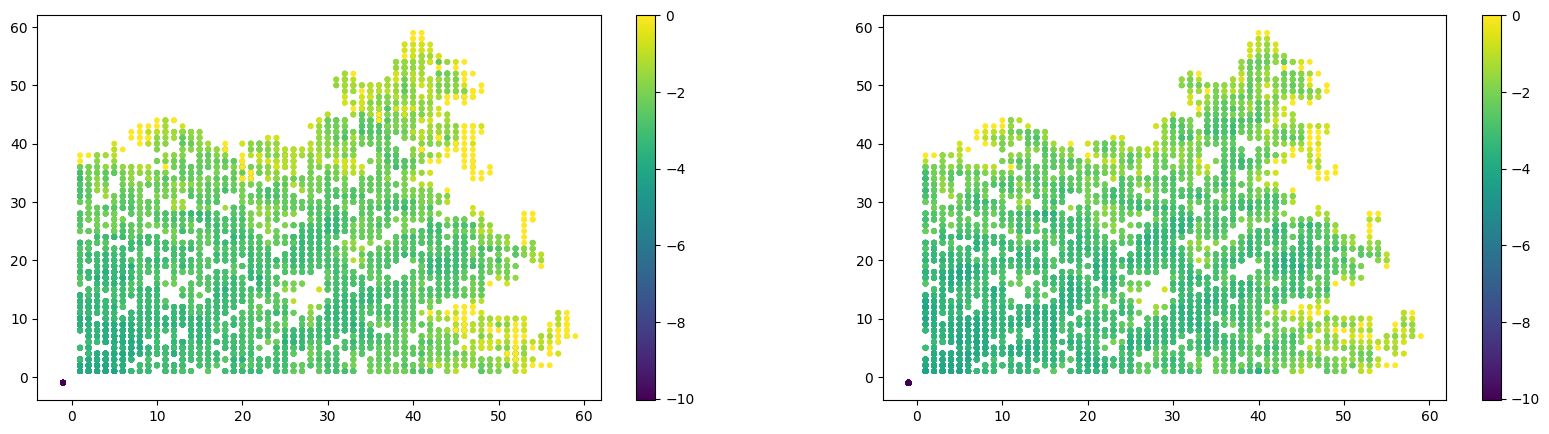

In [371]:
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.scatter(*latents.numpy().T, c=prod_dfs.numpy(), s=10.)
plt.colorbar()
plt.subplot(122)
plt.scatter(*latents.numpy().T, c=prod_novelty.numpy(), s=10.)
plt.colorbar()

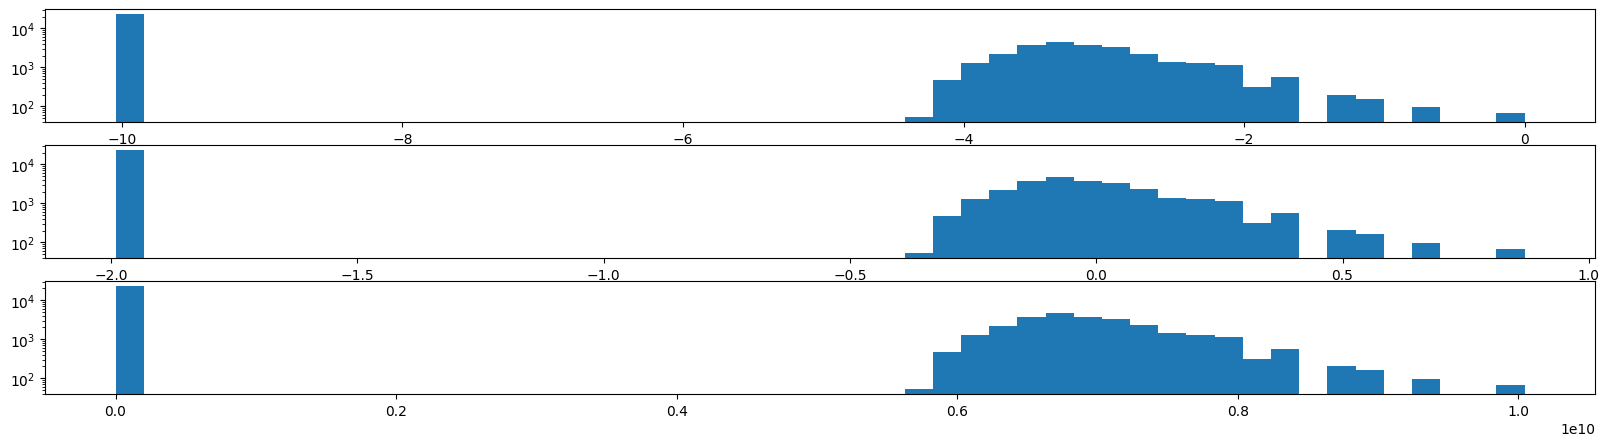

In [372]:
plt.figure(figsize=(20, 5))
# a = torch.tensor([node2prod[node] for node in ge if node.latent!=(-1, -1)])
plt.subplot(311)
plt.hist(prod, bins=50);
plt.yscale('log')

plt.subplot(312)
# plt.hist(normalize(prod), bins=50);
plt.hist(normalize(prod, devs=1.5), bins=50);
plt.yscale('log')

plt.subplot(313)
plt.hist(prod_norm, bins=50);
plt.yscale('log')

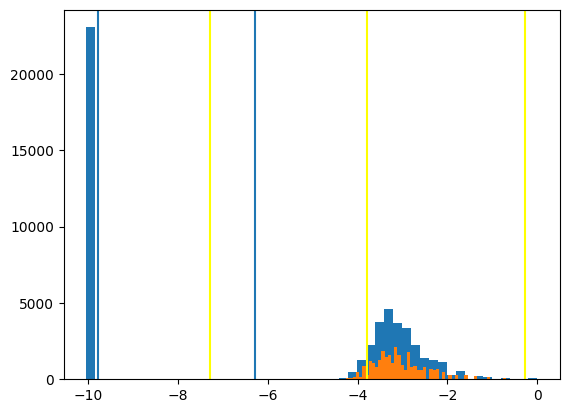

In [373]:
mask = ((prod-prod.median())/prod.std()).abs()<1.
plt.hist(prod.numpy(), bins=50);
plt.axvline(prod.mean().item())
plt.axvline(prod.mean().item()-prod.std().item())
plt.axvline(prod.median().item(), c='yellow')
plt.axvline(prod.median().item()-prod.std().item(), c='yellow')
plt.axvline(prod.median().item()+prod.std().item(), c='yellow')
plt.hist(prod[mask].numpy(), bins=50);
# plt.axvline(prod.median().item())
plt.show()

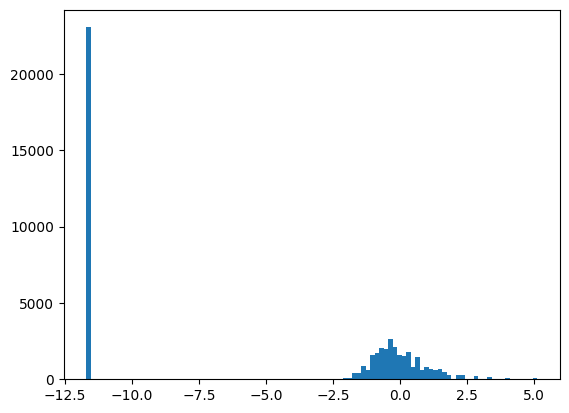

In [377]:
plt.hist(prod_norm, bins=100);

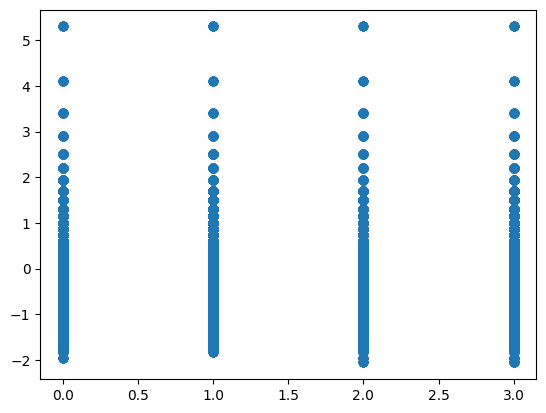

torch.Size([26953]) torch.Size([26953])
Average productivity of taking action 0: 0.05669889226555824
Average productivity of taking action 1: 0.05382400006055832
Average productivity of taking action 2: -0.0456048958003521
Average productivity of taking action 3: -0.013172546401619911


In [351]:
# action, prod
x = torch.stack([trans[2] for node in ge for trans in node.traj if node.latent!=(-1,-1)])
y = torch.tensor([prod_norm[i] for i, node in enumerate(ge) for trans in node.traj if node.latent!=(-1,-1)])
plt.scatter(x.numpy(), y.numpy())
plt.show()
print(x.shape, y.shape)
for i in range(4):
    print(f'Average productivity of taking action {i}: {y[x==i].mean().item()}')

torch.Size([26953, 3, 3]) torch.Size([26953]) torch.Size([26953])


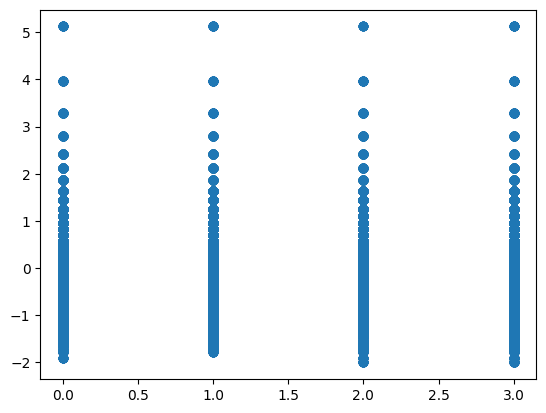

Average productivity of taking action 0: 0.0422724112868309
Average productivity of taking action 1: 0.03948799520730972
Average productivity of taking action 2: -0.05681214481592178
Average productivity of taking action 3: -0.025400351732969284


In [140]:
def plot_dataset(ge):
    obs = torch.stack([trans[1] for node in ge for trans in node.traj if node.latent!=(-1,-1)])
    action = torch.stack([trans[2] for node in ge for trans in node.traj if node.latent!=(-1,-1)])
    prod = torch.tensor([node2prod[node] for node in ge for trans in node.traj if node.latent!=(-1,-1)]).float()
    # prod = torch.tensor([-ge.cell2n_seen[node.latent] for node in ge for trans in node.traj if node.latent!=(-1,-1)]).float()
    prod = (prod-prod.mean())/(prod.std()+1e-9)
    print(obs.shape, action.shape, prod.shape)
    
    plt.scatter(action.numpy(), prod.numpy())
    plt.show()
    for i in range(4):
        print(f'Average productivity of taking action {i}: {prod[action==i].mean().item()}')
    
plot_dataset(ge)

In [355]:
prod_novelty = calc_prods_novelty(ge)
prod = prod_novelty
prod_norm = (prod-prod[mask].mean())/(prod[mask].std()+1e-9)

torch.Size([5000, 3, 3]) torch.Size([5000]) torch.Size([10]) torch.Size([50000])


  0%|          | 0/100 [00:00<?, ?it/s]

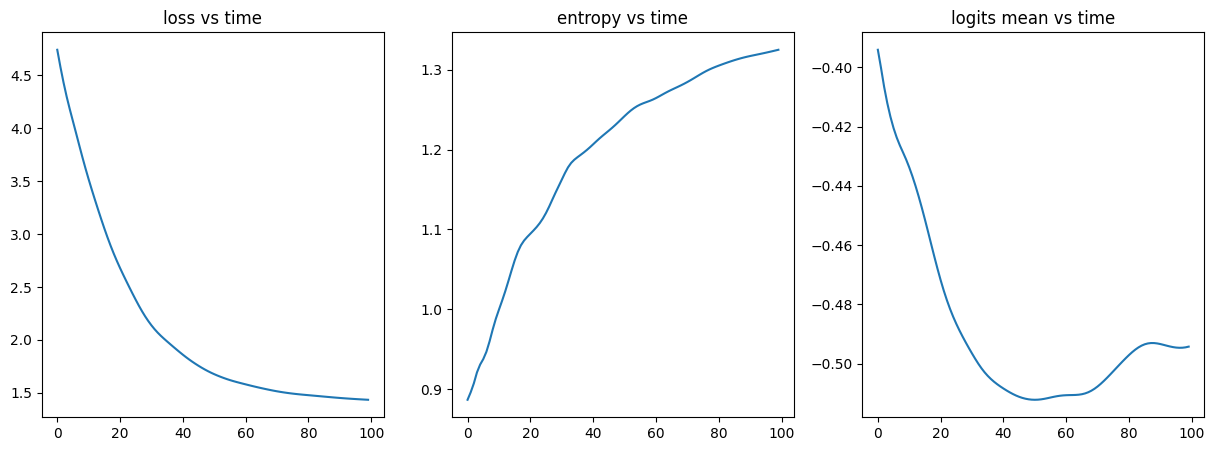

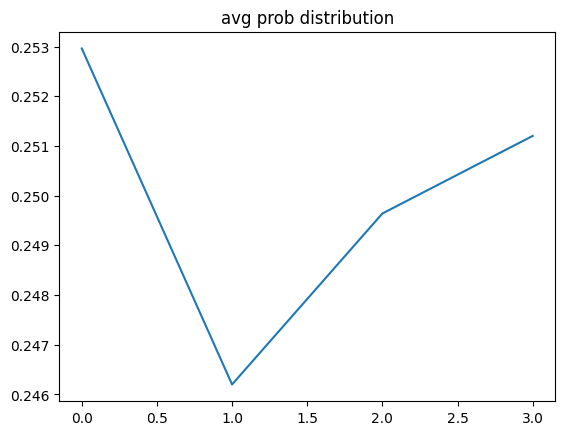

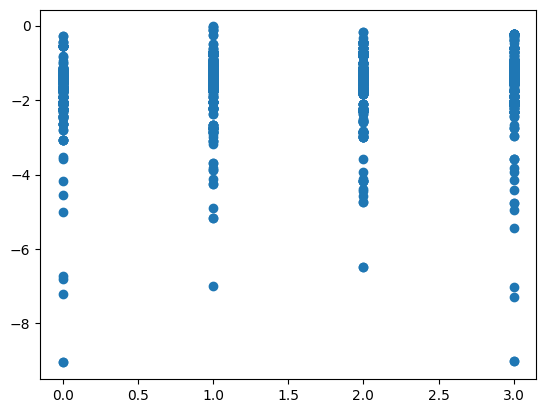

In [398]:
def step_policy(ge, explorer, opt, cal_prod, n_steps, batch_size=100, coef_entropy=1e-1, viz=False, device=None):
    # list of tuples (snapshot, obs, action, reward, done)
    obs = torch.stack([trans[1] for node in ge for trans in node.traj])
    action = torch.stack([trans[2] for node in ge for trans in node.traj])
    # done = torch.stack([trans[4] for node in ge for trans in node.traj])
    prod_novelty = calc_prod(ge)
    prod_norm = (prod-prod[mask].mean())/(prod[mask].std()+1e-9)
    r = prod_norm[1:]
    
    losses = []
    entropies = []
    logits_list = []
    pbar = tqdm(range(n_steps))
    for i_batch in pbar:
        idx = torch.randperm(len(obs))[:batch_size]
        b_obs, b_action, b_r = obs[idx].to(device), action[idx].to(device), r[idx].to(device)
        # if norm_batch:
            # b_prod = (b_prod-b_prod.mean())/(b_prod.std()+1e-9)
            
        logits, values = explorer.get_logits_values(b_obs)
        logits_aug = b_r[:, None]*logits
        dist = torch.distributions.Categorical(logits=logits_aug)
        log_prob = dist.log_prob(b_action)
        entropy = dist.entropy()
        
        loss_data = (-log_prob).mean()
        loss_entropy = -entropy.mean()
        
        loss = loss_data + coef_entropy*loss_entropy

        opt.zero_grad()
        loss.backward()
        opt.step()
        
        losses.append(loss.item())
        entropies.append(entropy.mean().item())
        logits_list.append(logits.mean().item())
        
        pbar.set_postfix(loss=loss.item())

    if viz:
        plt.figure(figsize=(15, 5))
        plt.subplot(131); plt.plot(losses); plt.title('loss vs time')
        plt.subplot(132); plt.plot(entropies); plt.title('entropy vs time')
        plt.subplot(133); plt.plot(logits_list); plt.title('logits mean vs time')
        plt.show()
        
        plt.plot(logits.softmax(dim=-1).mean(dim=-2).detach().cpu().numpy())
        # plt.hist(logits.argmax(dim=-1).detach().cpu().numpy())
        # plt.ylim(.23, .27)
        plt.title('avg prob distribution')
        plt.show()
        
        plt.scatter(b_action.detach().cpu().numpy(), log_prob.detach().cpu().numpy())
        plt.show()
        # plt.scatter(b_prod.cpu().numpy(), loss1.detach().cpu().numpy())
        # plt.show()
        
        # for i in range(4):
            # print(f'Action {i}')
            # print(log_probs[batch_actions==i].mean().item())

    

  0%|          | 0/100 [00:00<?, ?it/s]

Reduced loss from 3178036.0 to 113895.1796875


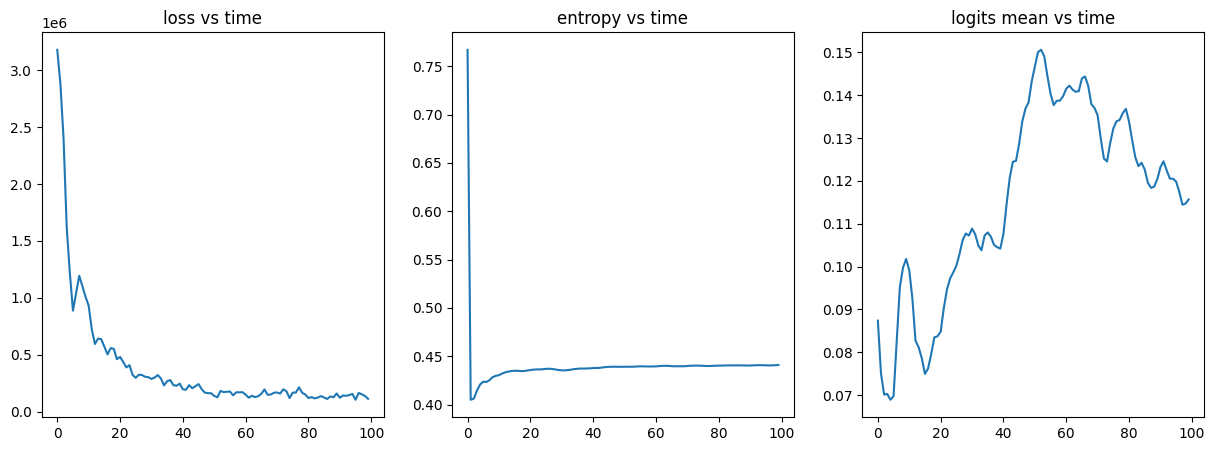

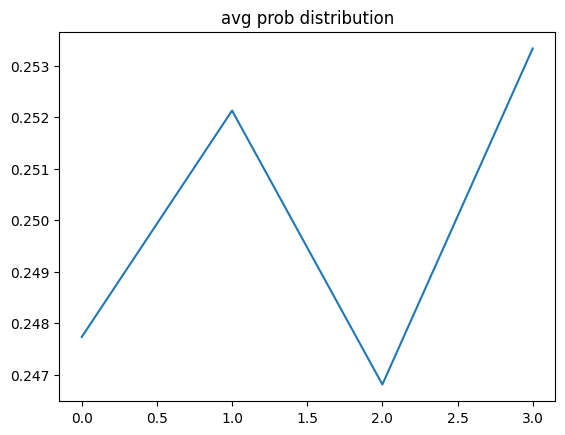

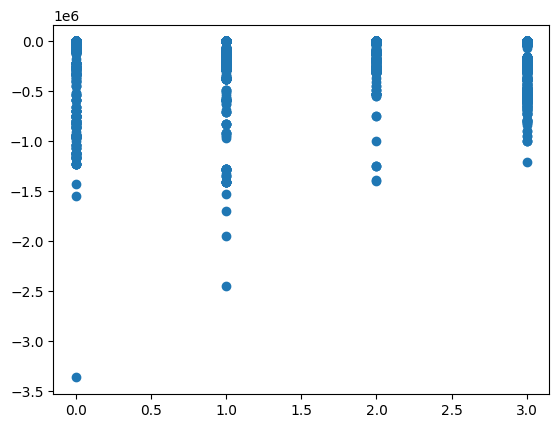

In [406]:
ex = ImitationExplorer(env).to(device)
opt = torch.optim.Adam(ex.parameters(), lr=1e-2)
step_policy(ge, ex, opt, calc_prods_novelty, 100, batch_size=5000, coef_entropy=0., viz=True, device=device)